In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms  # 公式の画像処理ライブラリ。データのロードや変換ができる

import numpy as np
import matplotlib.pyplot as plt

# MNISTの手書き文字認識
今回は、MNISTという手書き文字のデータセットを認識するタスクを行います

## データセット
まずはデータセットのダウンロードからです

In [ ]:
train_data = datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()) #テンソルに変換
test_data = datasets.MNIST('./data',
                   train=False,
                   download=True,
                   transform=transforms.ToTensor()) #テンソルに変換

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


実際のデータは下のように、手書き文字の画像(大きさ28x28)とそのラベルがペアになっています

label: 5


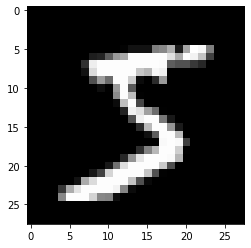

In [ ]:
plt.gray()
plt.imshow(train_data[0][0].numpy()[0])
print('label:', train_data[0][1])

pytorchでミニバッチ学習を行うためには、一度このデータセットを `torch.utils.DataLoader`に格納します

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

## モデル定義
まずはもっとも簡単に、全結合層のみでモデルを作成します

`nn.Module`を使うと、モデルの定義などの計算の流れをひとまとめにすることが可能です

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class NetFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 500) # 全結合層の定義
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)
        self.relu = nn.ReLU() # 活性化関数としてReLUを使用
        self.softmax= nn.Softmax(dim=-1) # 最後に確率値を出したいので、softmaxを使用

    def forward(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1) # (batch_size, 28, 28)から(batch_size, 784)に
        x = self.relu(self.fc1(x)) # 全結合層　-> 活性化関数
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(x)
        return x

モデルのインスタンスを作成　`model.train()`で学習モードに、`model.eval()`で評価モード（勾配計算がなされない）に変更できます

In [ ]:
model = NetFC()
model.to(device)

NetFC(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

先にオプティマイザとloss関数を定義します

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01) # model.parameters()でモデルに含まれる全てのパラメータが取得できる
criterion = nn.CrossEntropyLoss() # 今回はクロスエントロピーロスを使用

ここから学習のための関数を書いていきます

1. 勾配リセット
2. モデルの推論
3. 誤差計算
4. 誤差逆伝播
5. パラメータ更新

のステップを繰り返していきます

In [ ]:
def train(model, epoch):
    model.train()  # 学習モードをオンに
    train_loss = 0
    correct = 0
    for data, label in train_loader:
        # GPUへの転送
        data, label = data.to(device), label.to(device)
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(data)
        # 3. 誤差計算
        loss = criterion(output, label)
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()

        train_loss += loss.item() # item()を行うことで、勾配情報を破棄した値のみ取れる
        pred = output.argmax(dim=1, keepdim=True)  # 最大確率のインデックス取得
        correct += pred.eq(label.view_as(pred)).sum().item() # 正解数を記録

        # 学習経過を表示
    print('Train Epoch: {}, Loss: {:.6f}, Accuracy: ({:.0f}%)'.format(epoch,
                                                                      train_loss / len(train_loader.dataset),
                                                                      100*correct / len(train_loader.dataset)))

In [ ]:
def test(model, epoch):
    model.eval()# 学習モードをオフに
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 勾配を計算しない
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss += criterion(output, label).item()
            pred = output.argmax(dim=1, keepdim=True)  # 最大確率のインデックス取得
            correct += pred.eq(label.view_as(pred)).sum().item()


    print('Test Epoch: {}, Loss: {:.6f}, Accuracy: ({:.0f}%)'.format(epoch,
                                                                      test_loss / len(test_loader.dataset),
                                                                      100*correct / len(test_loader.dataset)))

今回は少々時間のかかる操作を行うので、`tqdm`でプログレスバーを表示させます

In [ ]:
#from tqdm import tqdm #コマンドラインで実行するとき
from tqdm import tqdm_notebook as tqdm # jupyter で実行するとき

実際に学習させます。69%くらいの正解率が出るはずです

In [ ]:
max_epoch = 10
for epoch in tqdm(range(max_epoch)):
    train(model, epoch)
    test(model, epoch)

Train Epoch: 0, Loss: 0.035984, Accuracy: (17%)
Test Epoch: 0, Loss: 0.023005, Accuracy: (31%)
Train Epoch: 1, Loss: 0.035938, Accuracy: (37%)
Test Epoch: 1, Loss: 0.022967, Accuracy: (42%)
Train Epoch: 2, Loss: 0.035861, Accuracy: (43%)
Test Epoch: 2, Loss: 0.022896, Accuracy: (43%)
Train Epoch: 3, Loss: 0.035684, Accuracy: (42%)
Test Epoch: 3, Loss: 0.022703, Accuracy: (40%)
Train Epoch: 4, Loss: 0.034836, Accuracy: (36%)
Test Epoch: 4, Loss: 0.021536, Accuracy: (34%)
Train Epoch: 5, Loss: 0.032544, Accuracy: (42%)
Test Epoch: 5, Loss: 0.020076, Accuracy: (52%)
Train Epoch: 6, Loss: 0.030717, Accuracy: (55%)
Test Epoch: 6, Loss: 0.019282, Accuracy: (56%)
Train Epoch: 7, Loss: 0.030020, Accuracy: (56%)
Test Epoch: 7, Loss: 0.019002, Accuracy: (57%)
Train Epoch: 8, Loss: 0.029312, Accuracy: (62%)
Test Epoch: 8, Loss: 0.018427, Accuracy: (66%)
Train Epoch: 9, Loss: 0.028604, Accuracy: (67%)
Test Epoch: 9, Loss: 0.018070, Accuracy: (69%)


# CNNを使った文字認識

全結合層を使うと、パラメータ数が多くなり、学習にも時間がかかります。  
そのため今度はMNISTをCNNで行ってみましょう

* 畳み込みは`nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)`で行うことができます。
* Max Poolingは`nn.MaxPool2d(kernel_size, stride, padding)`で行うことができます

In [ ]:
class NetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(64*7*7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # (b_size, 1, 28, 28) -> (b_size, 32, 28, 28)
        x = self.relu(self.conv1(x))
        # (b_size, 32, 28, 28) -> (b_size, 32, 14, 14)
        x = self.max_pool(x)
        # (b_size, 32, 14, 14) -> (b_size, 64, 14, 14)
        x = self.relu(self.conv2(x))
        # (b_size, 64, 14, 14) -> (b_size, 64, 7, 7)
        x = self.max_pool(x)
        # (b_size, 64, 7, 7) -> (b_size, 64*7*7)
        x = x.view(x.size()[0], -1)
        # (b_size, 64*7*7) -> (b_size, 100)
        x = self.fc1(x)
        # (b_size, 100) -> (b_size, 10)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

モデルの再定義

In [ ]:
model = NetCNN()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

85%くらいの正解率が出るはずです

In [ ]:
max_epoch = 10
for epoch in tqdm(range(max_epoch)):
    train(model, epoch)
    test(model, epoch)

Train Epoch: 0, Loss: 0.035945, Accuracy: (15%)
Test Epoch: 0, Loss: 0.022939, Accuracy: (13%)
Train Epoch: 1, Loss: 0.035467, Accuracy: (20%)
Test Epoch: 1, Loss: 0.021787, Accuracy: (47%)
Train Epoch: 2, Loss: 0.029052, Accuracy: (69%)
Test Epoch: 2, Loss: 0.016874, Accuracy: (81%)
Train Epoch: 3, Loss: 0.026033, Accuracy: (82%)
Test Epoch: 3, Loss: 0.016405, Accuracy: (84%)
Train Epoch: 4, Loss: 0.025639, Accuracy: (83%)
Test Epoch: 4, Loss: 0.016277, Accuracy: (84%)
Train Epoch: 5, Loss: 0.025487, Accuracy: (84%)
Test Epoch: 5, Loss: 0.016206, Accuracy: (85%)
Train Epoch: 6, Loss: 0.025390, Accuracy: (84%)
Test Epoch: 6, Loss: 0.016198, Accuracy: (85%)
Train Epoch: 7, Loss: 0.025325, Accuracy: (85%)
Test Epoch: 7, Loss: 0.016147, Accuracy: (85%)
Train Epoch: 8, Loss: 0.025265, Accuracy: (85%)
Test Epoch: 8, Loss: 0.016119, Accuracy: (85%)
Train Epoch: 9, Loss: 0.025210, Accuracy: (85%)
Test Epoch: 9, Loss: 0.016064, Accuracy: (86%)
